Grating


In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

resolution = 100  # pixels/um

pol = mp.Ex # Incident polarization

# Dimensions in um
l = 1.2
w = .090
a = 2*l # Lattice constant
gap = .070

t = 0.5 # Thickness in um

# Dimensions of the cell
sep = a - l # Sepparation between resonators
width = l + sep
height = l + sep

st = 10*a # Substrate thickness
depth = 2*st

cell = mp.Vector3(a, a, depth) # 3D cell

# PML layers
dpml = 2 # Width of the PML
pml = mp.PML(dpml, direction=mp.Z) # PML in the non-periodic direction

# Wavelengths in um
wmin = 1 # minimum wavelength
wmax = 5 # maximum wavelength
wcen = (wmax-wmin)/2 + wmin # central wavelength

fmin = 1/wmax # minimum frequency
fmax = 1/wmin # maximum frequency
fcen = (fmax-fmin)/2 + fmin # central frequency
nfreqs = 100 # number of frequencies calculated

sources = [
    mp.Source(mp.GaussianSource(fcen, fwidth=fmax-fmin),
              component=pol,
              center=mp.Vector3(0,0,-depth/2+dpml),
              size=mp.Vector3(a, a, 0)),
]

symmetries = [mp.Mirror(mp.X)]

Using MPI version 4.0, 1 processes


In [2]:
refl_fr = mp.ModeRegion(center=mp.Vector3(0,0,-depth/2+dpml+0.2), size=mp.Vector3(width, height, 0))
tran_fr = mp.ModeRegion(center=mp.Vector3(0,0,depth/2-dpml-0.1), size=mp.Vector3(width, height, 0))

In [3]:
c_ = 299792458
wp = 2.175e15/(c_*1e6) # Plasma frequency
gamma = 6.5e12/(c_*1e6) # Collision frequency
susc = mp.DrudeSusceptibility(frequency=wp, gamma=gamma*1.65, sigma=1)

Gold = mp.Medium(epsilon=1, E_susceptibilities=[susc])

In [4]:
from meep.materials import Au, SiO2, Ag

n_SiO2 = 1.4059

# substrate = SiO2
metal = Ag
substrate = mp.Medium(index=n_SiO2)

# Define the geometry
geometry = [
    mp.Block(size=mp.Vector3(mp.inf, mp.inf, mp.inf), center=mp.Vector3(0,0,depth/4), material=substrate),
    mp.Block(size=mp.Vector3(l, l, t), center=mp.Vector3(0, 0, -t/2), material=metal),
]

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=[pml],
    geometry=geometry,
    k_point=mp.Vector3(0,0,0), # Periodicity
    sources=sources,
    # symmetries=symmetries,
    resolution=resolution)

refl = sim.add_mode_monitor(fcen, fmax-fmin, nfreqs, refl_fr)
tran = sim.add_mode_monitor(fcen, fmax-fmin, nfreqs, tran_fr)

freqs = mp.get_flux_freqs(refl)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000185013 s
Working in 3D dimensions.
Computational cell is 2.4 x 2.4 x 48 with resolution 25
     block, center = (0,0,12)
          size (1e+20,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.97655,1.97655,1.97655)
     block, center = (0,0,-0.25)
          size (1.2,1.2,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
subpixel-averaging is 82.8487% done, 0.828078 s remaining
subpixel-averaging is 81.3571% done, 0.916741 s remaining
subpixel-averaging is 83.6313% done, 0.782919 s remaining
time for set_epsilon = 15.9208 s
lorentzian susceptibility: frequency=16.365, gamma=1.95106
lorentzian susceptibility: frequency=7.32593, gamma=0.738804
lorentzian susceptibility: frequency=6.60165, gamma=0.052426
lorentzian susceptibility: frequency=3.61417, gamma=0.364563
lorentzian susceptibility: frequency=0.65814

     block, center = (0,0,12)
          size (1e+20,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.97655,1.97655,1.97655)
     block, center = (0,0,-0.25)
          size (1.2,1.2,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


/home/gridsan/mcomella/.conda/envs/pmp/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/gridsan/mcomella/.conda/envs/pmp/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


<AxesSubplot:xlabel='X', ylabel='Y'>

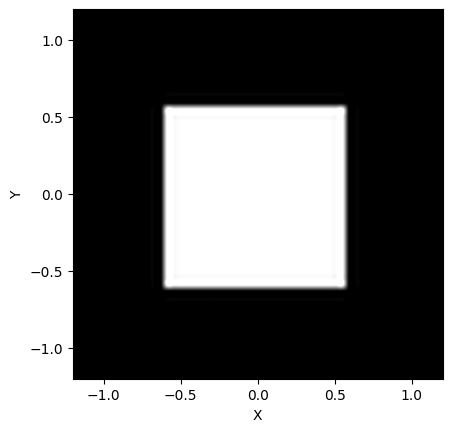

In [5]:
sim.plot2D(output_plane=mp.Volume(size=mp.Vector3(width, height, 0), center=mp.Vector3(0,0,-t/2)))

     block, center = (0,0,12)
          size (1e+20,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.97655,1.97655,1.97655)
     block, center = (0,0,-0.25)
          size (1.2,1.2,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


<AxesSubplot:xlabel='X', ylabel='Z'>

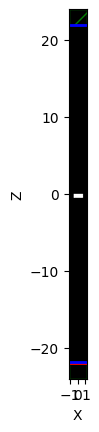

In [6]:
sim.plot2D(output_plane=mp.Volume(size=mp.Vector3(a, 0, depth), center=mp.Vector3(0,0,0)))

In [7]:
# from playsound import playsound

pt = mp.Vector3(0,0,depth/2-dpml-0.1)
sim.run(until_after_sources=mp.stop_when_fields_decayed(50,pol,pt,0.001))

# playsound('alarm.mp3')

refl_flux = mp.get_fluxes(refl)
tran_flux = mp.get_fluxes(tran)

on time step 1 (time=0.02), 6.77726 s/step
on time step 11 (time=0.22), 0.406697 s/step
on time step 21 (time=0.42), 0.40035 s/step
on time step 31 (time=0.62), 0.403646 s/step
on time step 42 (time=0.84), 0.396559 s/step
on time step 53 (time=1.06), 0.391943 s/step
on time step 64 (time=1.28), 0.393624 s/step
on time step 75 (time=1.5), 0.396018 s/step
on time step 86 (time=1.72), 0.392439 s/step
on time step 97 (time=1.94), 0.398244 s/step
on time step 107 (time=2.14), 0.405769 s/step
on time step 117 (time=2.34), 0.402416 s/step
on time step 127 (time=2.54), 0.400696 s/step
on time step 138 (time=2.76), 0.396331 s/step
on time step 148 (time=2.96), 0.402108 s/step
on time step 158 (time=3.16), 0.403012 s/step
on time step 169 (time=3.38), 0.398455 s/step
on time step 180 (time=3.6), 0.39878 s/step
on time step 190 (time=3.8), 0.403601 s/step
on time step 201 (time=4.02), 0.392913 s/step
on time step 212 (time=4.24), 0.394901 s/step
on time step 223 (time=4.46), 0.398087 s/step
on ti

RuntimeError: meep: simulation fields are NaN or Inf

     block, center = (0,0,2.25)
          size (1e+20,1e+20,4.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.97655,1.97655,1.97655)
     block, center = (0,0,-0.01)
          size (0.32,0.32,0.02)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


<AxesSubplot:xlabel='Y', ylabel='Z'>

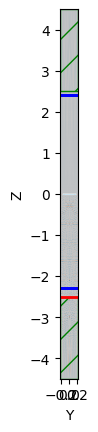

In [ ]:
sim.plot2D(output_plane=mp.Volume(size=mp.Vector3(0, a, depth), center=mp.Vector3(0,0,0)), fields=pol)

In [ ]:
wl = []
for i in range(nfreqs):
    wl = np.append(wl, 1/freqs[i])

---
#### S parameters

In [ ]:
S11 = sim.get_eigenmode_coefficients(refl, [1]).alpha[0]
S21 = sim.get_eigenmode_coefficients(tran, [1]).alpha[0]

MPB solved for frequency_1(0,0,0.2) = 0.2 after 5 iters
Dominant planewave for band 1: (0.000000,0.000000,0.200000)
MPB solved for frequency_1(0,0,0.208081) = 0.208081 after 5 iters
Dominant planewave for band 1: (0.000000,0.000000,0.208081)
MPB solved for frequency_1(0,0,0.216162) = 0.216162 after 5 iters
Dominant planewave for band 1: (0.000000,0.000000,0.216162)
MPB solved for frequency_1(0,0,0.224242) = 0.224242 after 5 iters
Dominant planewave for band 1: (0.000000,0.000000,0.224242)
MPB solved for frequency_1(0,0,0.232323) = 0.232323 after 5 iters
Dominant planewave for band 1: (0.000000,0.000000,0.232323)
MPB solved for frequency_1(0,0,0.240404) = 0.240404 after 5 iters
Dominant planewave for band 1: (0.000000,0.000000,0.240404)
MPB solved for frequency_1(0,0,0.248485) = 0.248485 after 5 iters
Dominant planewave for band 1: (0.000000,0.000000,0.248485)
MPB solved for frequency_1(0,0,0.256566) = 0.256566 after 5 iters
Dominant planewave for band 1: (0.000000,0.000000,0.256566)
MP

In [ ]:
a = np.array([coef[1] for coef in S11])
b = np.array([coef[0] for coef in S21])
c = np.array([coef[0] for coef in S11])

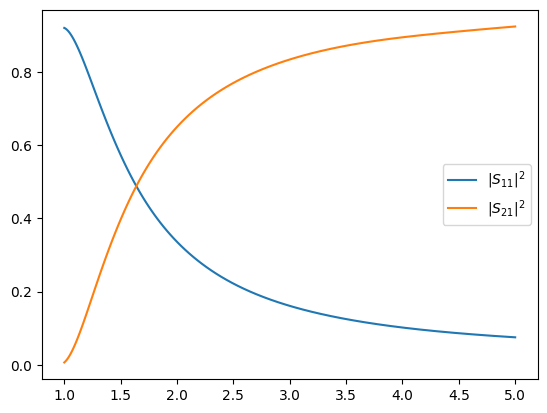

In [ ]:
plt.plot(wl, np.abs(a/c)**2, label='$|S_{11}|^2$')
plt.plot(wl, np.abs(b/c)**2, label='$|S_{21}|^2$')
plt.legend()

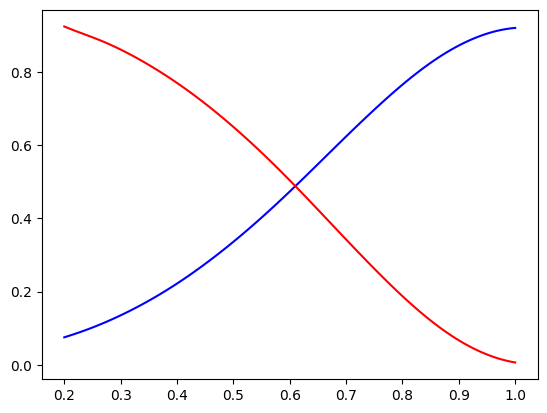

In [ ]:
import matplotlib.pyplot as plt
plt.plot(freqs, np.abs(a/c)**2, 'b', label='$|S_{11}|^2$')
plt.plot(freqs, np.abs(b/c)**2, 'r', label='$|S_{12}|^2$')

Save S parameters to xlsx file

In [ ]:
# Save S parameter data to xmls
import pandas as pd

f = np.array(freqs)
df = pd.DataFrame(data={'f': f, 'R': a/c, 'T': b/c, 'a': a, 'b': b, 'c': c})
df.to_excel('s_params_yy.xlsx')

In [ ]:
str(mp.Ex)

'0'

---

#### Retrieval

In [ ]:
k = 2*np.pi/wl
prepad = st-dpml-0.2-t # Distance between reflection monitor and metamaterial
postpad = st-dpml-0.1 # Distance between metamaterial back and transmission monitor

S11 = a/c * np.exp(-1j*k*(2*prepad+0.2))
S21 = b/c * np.exp(-1j*k*(prepad+0.2)-1j*k*n_SiO2*postpad)

S11 = a/c * np.exp(-1j*k*(2*prepad))
S21 = b/c * np.exp(-1j*k*prepad-1j*k*n_SiO2*postpad)

In [ ]:
# Save S parameters
import pandas as pd
df = pd.DataFrame(data={'f': f, 'R': S11, 'T': S21})
df.to_excel('MATLAB/new_s_params.xlsx', index=False)

OSError: Cannot save file into a non-existent directory: 'MATLAB'

In [ ]:
def retrieve(S11, S21, branch=0):
    z = np.sqrt(((1+S11)**2-S21**2)/((1-S11)**2-S21**2))
    einkd = S21/(1 - S11*(z-1)/(z+1))
    n = 1/(k*t) * (np.imag(np.log(einkd))+2*np.pi*branch - 1j*np.real(np.log(einkd)))

    eps = n/z
    mu = n*z

    return [eps, mu, n, z]

In [ ]:
[eps, mu, n, z] = retrieve(S11, S21, 0)

plt.figure(dpi=100)
plt.plot(freqs*c_/1e6, np.real(eps), label='$\operatorname{Re}(\epsilon)$')
plt.plot(freqs*c_/1e6, 10*np.real(mu), label='$10\operatorname{Re}(\mu)$')
plt.plot(freqs*c_/1e6, np.zeros(nfreqs), '--', color='black')
plt.legend()

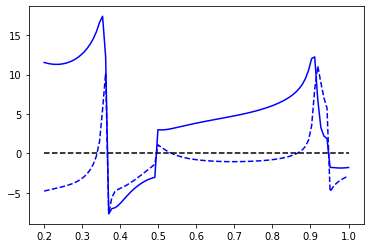

In [ ]:
plt.figure()
plt.plot(freqs, np.real(n), 'blue')
plt.plot(freqs, np.imag(n), 'blue', linestyle='dashed')
plt.plot(freqs, np.zeros(nfreqs), '--', color='black')

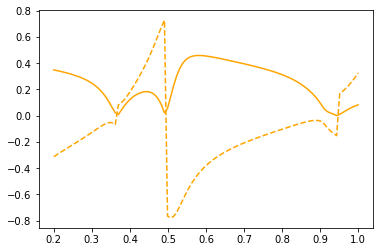

In [ ]:
plt.figure()
# plt.plot(freqs, np.real(n), 'blue')
# plt.plot(freqs, np.imag(n), 'blue', linestyle='dashed')
plt.plot(freqs, np.real(z), 'orange')
plt.plot(freqs, np.imag(z), 'orange', linestyle='dashed')

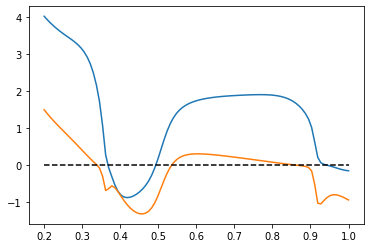

In [ ]:
plt.figure()
plt.plot(freqs, np.real(n)*np.real(z))
plt.plot(freqs, np.imag(n)*np.imag(z))
plt.plot(freqs, np.zeros(nfreqs), '--', color='black')

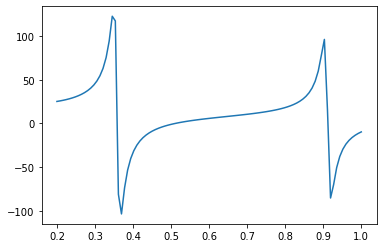

In [ ]:
tmp = (np.real(n)*np.real(z)+np.imag(n)*np.imag(z))/(np.real(z)**2+np.imag(z)**2)
plt.plot(freqs, tmp)

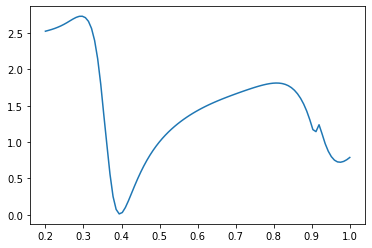

In [ ]:
plt.plot(freqs, np.real(n)*np.real(z)-np.imag(n)*np.imag(z))